# Modelling

The objective fo this notebook is to utilize some methods to find and determine the optimal model to solve the challenge problem. 

## Libraries

In [1]:
import numpy as np 
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import tsfresh
from statsmodels.tsa.seasonal import STL


from sklearn.model_selection import TimeSeriesSplit, train_test_split
from collections import deque
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb

## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 1 Training Data is used.

In [2]:
full_data = get_selected_features(0)

full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')


full_label = pd.read_csv('Data/Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [3]:
X = X.drop(['ID','WF','Set'],axis=1)

In [4]:
X

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,...,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Min,CLCT_Expanded_Window_Min,U_100m_Expanded_Window_Min,V_100m_Expanded_Window_Min,U_10m_Expanded_Window_Min,V_10m_Expanded_Window_Min
Time,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,5.789500,3.820200,1.054669,1.317597,275.690000,86.504507,6.936299,0.583268,1.687717,0.895782,...,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,6.003300,3.920600,0.876879,1.483483,275.770000,98.976088,7.170127,0.578533,1.723264,1.036951,...,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,5.931829,0.907656,0.949640,1.419591,276.875000,64.193607,6.000870,0.151837,1.707938,0.981212,...,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,5.205300,1.683800,1.027462,1.029786,275.650000,57.482484,5.470862,0.312855,1.454695,0.786528,...,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,4.845900,0.702200,1.011645,0.785352,275.530000,89.971463,4.896512,0.143904,1.280704,0.660129,...,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-15 20:00:00,2.170110,4.748240,0.462829,1.631609,276.524000,89.425555,5.220648,1.142108,1.695983,1.294393,...,1.715289,1.530441,0.016556,0.072773,307.274,100.000000,17.1042,17.7640,10.842949,10.904905
2019-01-15 21:00:00,2.065587,4.498405,-0.017954,1.710876,276.673866,92.405352,4.949979,1.140333,1.710970,358.439698,...,1.742569,1.574651,0.009329,0.058382,307.274,100.000000,17.1042,17.7640,10.842949,10.904905
2019-01-15 22:00:00,2.309620,5.293530,-0.047004,1.605355,276.007000,94.662612,5.775448,1.159385,1.606043,358.458475,...,1.736238,1.619585,0.010982,0.028738,307.274,100.000000,17.1042,17.7640,10.842949,10.904905


Here, differentiation (numpy.diff) is applied to the data, before the model is trained.

In [5]:
#X = transform_data(X)

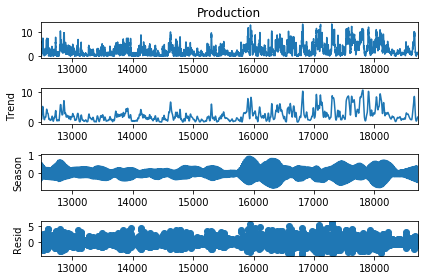

In [6]:
stl = STL(y['Production'],period=20,seasonal=29)
res = stl.fit()
fig = res.plot()

In [7]:
y_trend = res.trend
y_season = res.seasonal

In [8]:
y_season

12478    0.175689
12479    0.223630
12480    0.297349
12481   -0.300866
12482   -0.492413
           ...   
18712   -0.493331
18713   -0.475944
18714   -0.521239
18715   -0.063213
18716   -0.264985
Name: season, Length: 6239, dtype: float64

## Validation Scheme

Before proceeding to the Hyperparameter search, it is necessary first to have some way to reliably measure the performance of the model. For this purpose, it will be used a Time Split Cross Validation Method, were the "Test" Fold for each Iteration is going to be used as the Validation Data, and so, to make Early Stopping on the data.

In [9]:
k_fold_splits = 5
num_boost_round = 1000
early_stopping_rounds = 50

In [10]:
def gpu_df(df,y):
    gpu_matrix = cp.asarray(df)
    gpu_matrix = xgb.DMatrix(gpu_matrix,label=y)
    return gpu_matrix

In [11]:
def objective_1(param,k_fold_splits=k_fold_splits,num_boost_round=num_boost_round,early_stopping_rounds=early_stopping_rounds):
    # Define Time Split Cross Validation
    tscv = TimeSeriesSplit(n_splits=k_fold_splits)

    # Separating Data from Hold Out Set
    X_cv, X_hold, y_cv, y_hold = train_test_split(X, y_trend, test_size=0.125, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.125, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=False)

    # Apply GPU-DF Transformation
    dtrain = gpu_df(X_train,y_train)
    dval = gpu_df(X_val,y_val)
    dtest = gpu_df(X_test,y_test)

    # Set XGBoost for GPU
    param['tree_method'] = 'gpu_hist'

    progress = dict()
    watchlist = [(dtrain,'train'),(dval,'eval')]
    bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

    # Train and Validation Score
    train_score = np.array(progress['train']['CAPE']).mean()
    val_score = np.array(progress['eval']['CAPE']).mean()

    # Test Score
    preds = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
    test_score = metric_cnr(preds,dtest)

    return {'loss' : test_score[1], 'params' : param, 'status' : STATUS_OK, 'train_loss' : train_score, 'val_loss' : val_score}

In [12]:
def objective_2(param,k_fold_splits=k_fold_splits,num_boost_round=num_boost_round,early_stopping_rounds=early_stopping_rounds):
    # Define Time Split Cross Validation
    tscv = TimeSeriesSplit(n_splits=k_fold_splits)

    # Separating Data from Hold Out Set
    X_cv, X_hold, y_cv, y_hold = train_test_split(X, y_season, test_size=0.125, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.125, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=False)

    # Apply GPU-DF Transformation
    dtrain = gpu_df(X_train,y_traintrue_values)
    dval = gpu_df(X_val,y_valtrue_values)
    dtest = gpu_df(X_test,y_testtrue_values)

    # Set XGBoost for GPU
    param['tree_method'] = 'gpu_hist'

    progress = dict()
    watchlist = [(dtrain,'train'),(dval,'eval')]
    bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

    # Train and Validation Score
    train_score = np.array(progress['train']['CAPE']).mean()
    val_score = np.array(progress['eval']['CAPE']).mean()

    # Test Score
    preds = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
    test_score = metric_cnr(preds,dtest)

    return {'loss' : test_score[1], 'params' : param, 'status' : STATUS_OK, 'train_loss' : train_score, 'val_loss' : val_score}

## Hyperparameter Tuning

For the Hyperparameter Tuning, the HyperOpt Library will be used, which implements some techniques for a more efficient search for parameters.

### Domain Space

Here, the Domain Space which will be searched is defined.

In [13]:
space = {
    'max_depth' : hp.choice('max_depth', np.arange(1,20,dtype=int)),
    'subsample' : hp.uniform('subsample', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 1000),
    'lambda' : hp.uniform('lambda', 0, 100),
    'alpha' : hp.uniform('alpha', 0, 100),
    'eta' : hp.uniform('eta', 0, 5)
}

### Optimization Algorithm

Here, the Optimization Method is selected, and a Trials Object, used for get acess to info from the Optimzation Trails, is defined. Here the Tree of Parzen Estimators (TPE) is selected for the Optimization Method.

In [14]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()

### Bayesian Optimization

Here, the Optimization is properly run.

In [15]:
MAX_EVALS = 300

In [16]:
best_1 = fmin(fn = objective_1, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 300/300 [08:09<00:00,  1.63s/trial, best loss: 25.08135203585682]


In [17]:
best_2 = fmin(fn = objective_2, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 300/300 [00:00<00:00, 299735.87trial/s, best loss=?]


In [18]:
best = {'alpha': 31.900831462840383,
        'colsample_bylevel': 0.3684140632736379,
        'colsample_bytree': 0.9204134654027759,
        'eta': 0.1, #1.071575096497831
        'lambda': 500, #46.738461107650394
        'max_depth': 4,
        'min_child_weight': 171.325997666389,
        'subsample': 0.9553482889926606,
        'validate_parameters': 1}

### Hold Out Score

Trend Data

In [32]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_trend, test_size=0.125, shuffle=False)
dhold = gpu_df(X_holdout,y_holdout)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)
dtrain = gpu_df(X_train,y_train)
dval = gpu_df(X_val,y_val)

In [34]:
progress = dict()
watchlist = [(dtrain,'train'),(dval,'eval')]
bst = xgb.train(best, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

In [35]:
preds_trend = bst.predict(dhold,ntree_limit=bst.best_ntree_limit)

Seasonal Data

In [36]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_season, test_size=0.125, shuffle=False)
dhold = gpu_df(X_holdout,y_holdout)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)
dtrain = gpu_df(X_train,y_train)
dval = gpu_df(X_val,y_val)

In [38]:
progress = dict()
watchlist = [(dtrain,'train'),(dval,'eval')]
bst = xgb.train(best_2, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

In [39]:
preds_season = bst.predict(dhold,ntree_limit=bst.best_ntree_limit)

Results

In [40]:
_, X_holdout, _, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
dhold = gpu_df(X_holdout,y_holdout['Production'])

In [41]:
preds = preds_trend #+ preds_season
score = metric_cnr(preds,dhold)

The Score for the HoldOut Set is shown here.

In [42]:
print(score)

('CAPE', 34.78737382171881)


In [43]:
_,  _, _, true_values = train_test_split(X, y, test_size=0.125, shuffle=False)

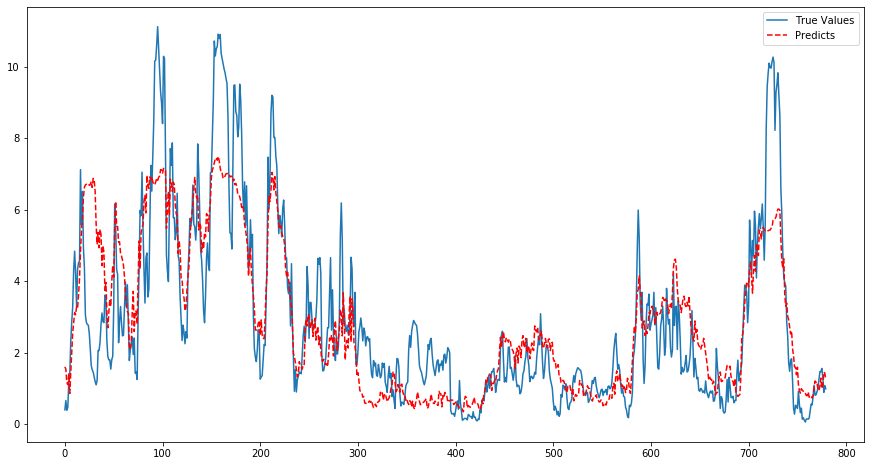

In [44]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(dhold.get_label()))
plt.plot(preds_len,true_values['Production'],label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Generating Predictions

Finally, the best model selected is applied to all Wind Farms separately, using all Training Data for Training and Predicting all the Test Data at once (At least for the moment).

In [21]:
best

{'alpha': 42.770151709159535,
 'colsample_bylevel': 0.4388961520315628,
 'colsample_bytree': 0.955914192653939,
 'eta': 1.8865924839755306,
 'lambda': 57.155438188730464,
 'max_depth': 0,
 'min_child_weight': 92.39917076686672,
 'subsample': 0.9542902708438747,
 'validate_parameters': 1}

In [48]:
preds = []
for WF in full_data['WF'].unique():
    X_WF = full_data[full_data['WF']==WF]
    X_train = X_WF[X_WF['Set']=='Train']
    y_train = full_label[full_label['ID'].isin(X_train['ID'])]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    X_test = X_WF[X_WF['Set']=='Test']

    #Transform Data
    #X_train = transform_data(X_train.drop(['ID','WF','Set'],axis=1))
    #X_test = transform_data(X_test.drop(['ID','WF','Set'],axis=1))
    X_train = X_train.drop(['ID','WF','Set'],axis=1)
    X_val = X_val.drop(['ID','WF','Set'],axis=1)
    X_test = X_test = X_test.drop(['ID','WF','Set'],axis=1)
    
    dtrain = gpu_df(X_train,y_train['Production'])
    dval = gpu_df(X_val,y_val['Production'])
    dtest = gpu_df(X_test,None)
    
    bst = xgb.train(best, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)
    pred = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

    preds = np.append(preds,pred)

### Generate Submissions

In [49]:
preds_id = pd.read_csv(r'C:\Users\andre_\OneDrive\Documentos\GitHub\cnr\Data\random_submission_example.csv')['ID']

In [50]:
submission = pd.DataFrame()
submission['ID'] = preds_id
submission['Production'] = preds
submission = submission.set_index('ID')

In [51]:
submission.to_csv(r'C:\Users\andre_\OneDrive\Documentos\GitHub\cnr\Data/Submission_XGB.csv')

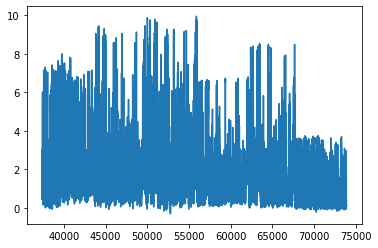

In [52]:
plt.plot(submission.index,submission['Production'])